# gkmsvm comparison analysis

In [1]:
### header ###
__author__ = "Jenhan Tao"
__license__ = "BSD"
__email__ = "jenhantao@gmail.com"

### imports ###
import sys
import os
import pandas as pd
import numpy as np
import argparse
import matplotlib
import itertools
import scipy
import matplotlib.pyplot as plt 
import seaborn as sns
import scipy
import pickle
from sklearn import preprocessing
import sklearn
from sklearn import decomposition
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn import svm, datasets
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc
from sklearn import ensemble
from sklearn import neighbors
import matplotlib_venn
from sklearn.cross_validation import train_test_split
from random import shuffle

### notebook specific configuration ###
%matplotlib inline
matplotlib.pylab.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(5000)
os.chdir('/gpfs/data01/glasslab/home/jtao/analysis/method_comparison_analysis/')
sns.set_context('notebook')
%load_ext autoreload
%autoreload 2
%env PATH=/gpfs/data01/glasslab/home/jtao/perl5/bin:/gpfs/data01/glasslab/home/jtao/software/anaconda3/bin:/home/jtao/software/bin:/usr/local/sbin:/usr/sbin:/usr/bin:/usr/local/bin:/usr/bin:/gpfs/data01/glasslab/home/jtao/software/homer/bin:/gpfs/data01/glasslab/home/jtao/software/weblogo:/home/jtao/code/seq_merge_pipe:/home/vlink/mouse_strains/marge/shifting:/bioinformatics/glassutils/scripts:/bioinformatics/software/meme/bin:/home/jtao/software/lsgkm/bin

env: PATH=/gpfs/data01/glasslab/home/jtao/perl5/bin:/gpfs/data01/glasslab/home/jtao/software/anaconda3/bin:/home/jtao/software/bin:/usr/local/sbin:/usr/sbin:/usr/bin:/usr/local/bin:/usr/bin:/gpfs/data01/glasslab/home/jtao/software/homer/bin:/gpfs/data01/glasslab/home/jtao/software/weblogo:/home/jtao/code/seq_merge_pipe:/home/vlink/mouse_strains/marge/shifting:/bioinformatics/glassutils/scripts:/bioinformatics/software/meme/bin:/home/jtao/software/lsgkm/bin


## Functions

In [2]:
# split data into GC content matched training and test data
def get_GC_matched_split(features, labels, test_size, tolerance = 0.01):
    '''
    feature: 2D array (samples x features)
    labels: 1D boolean array (samples x)
    test_size: fraction of data to test on
    tolerance: max difference in GC content between True and False labelled samples
    '''
    global _id_sequence_dict
    
    ### match GC content of samples labelled True with those labelled False by thowing out False samples
    # retrieve sequences using index of labels
    index_label_tuples = tuple(zip(labels.index.values, labels.values))
    
    true_sequences = [_id_sequence_dict[x[0]] for x in index_label_tuples if x[1]]
    true_ids = [x[0] for x in index_label_tuples if x[1]]
    
    false_sequences = [_id_sequence_dict[x[0]] for x in index_label_tuples if not x[1]]
    false_ids = [x[0] for x in index_label_tuples if not x[1]]
    
    # calculate GC content of True samples
    true_gc_count = 0
    true_length = 0
    for s in true_sequences:
        true_gc_count += s.count('G')
        true_gc_count += s.count('C')
        true_length += len(s)
    true_gc_content = true_gc_count/(true_length+0.0000001)
    
    # calcuate GC content of False samples
    false_gc_count = 0
    false_length = 0
    for s in false_sequences:
        false_gc_count += s.count('G')
        false_gc_count += s.count('C')
        false_length += len(s)
    false_gc_content = false_gc_count/(false_length+0.0000001)
    
    while abs(true_gc_content - false_gc_content) > tolerance:
        # remove false GC sequences until GC content matches tolerance
        selected_seq = False
        
        while not selected_seq:
            rand_index = np.random.randint(len(false_sequences))
            current_seq = false_sequences[rand_index]
            current_gc_count = current_seq.count('G')+ current_seq.count('C')
            current_length = len(current_seq)
            current_gc = current_gc_count/current_length
            if true_gc_content > false_gc_content:
                # remove sequences that would increase overall GC content of False sequences
                if current_gc < false_gc_content:
                    selected_seq = True
            else:
                # remove sequences that would decrease overall GC content of False sequences
                if current_gc > false_gc_content:
                    selected_seq = True
        false_gc_count -= current_gc_count
        false_length -= current_length
        false_gc_content = false_gc_count/false_length
        
        false_sequences.pop(rand_index)
        false_ids.pop(rand_index)
    
    filtered_ids = true_ids + false_ids
    filtered_features = features[features.index.isin(filtered_ids)]
    filtered_labels = labels[labels.index.isin(filtered_ids)]

    if test_size <= 0.5:
        training_indices, test_indices = next(iter(
                sklearn.cross_validation.StratifiedKFold(filtered_labels, int(1/test_size), shuffle=True)))
    else:
        test_indices, training_indices = next(
            iter(sklearn.cross_validation.StratifiedKFold(filtered_labels, int(1/(1-test_size)), shuffle=True)))
    training_ids = [filtered_ids[i] for i in training_indices]
    test_ids = [filtered_ids[i] for i in test_indices]
    
    training_features = filtered_features[filtered_features.index.isin(training_ids)]
    test_features = filtered_features[filtered_features.index.isin(test_ids)]
    training_labels = filtered_labels[filtered_labels.index.isin(training_ids)]
    test_labels = filtered_labels[filtered_labels.index.isin(test_ids)]
    
    return training_features, test_features, training_labels, test_labels
    

## Read in Score Files

In [3]:
motif_score_frame=pd.read_pickle('motif_score_frame_C57BL6J.pickle')
motif_sequence_frame = pd.read_pickle('motif_sequence_frame_C57BL6J.pickle')
motif_strand_frame = pd.read_pickle('motif_strand_frame_C57BL6J.pickle')
motif_start_frame = pd.read_pickle('motif_start_frame_C57BL6J.pickle')
motif_end_frame = pd.read_pickle('motif_end_frame_C57BL6J.pickle')
summary_frame = pd.read_pickle('summary_frame.pickle')
annotation_frame = pd.read_pickle('annotation_frame.pickle')

motif_summedScore_frame=pd.read_pickle('motif_summedScore_frame_C57BL6J.pickle')
# motif_summedScore_frame = motif_summedScore_frame.ix[:,3:]

# normed_motif_frame = pd.DataFrame(preprocessing.normalize(merged_motif_frame.ix[:,3:], axis=0))
scaler = preprocessing.MinMaxScaler()
normed_motif_frame = pd.DataFrame(scaler.fit_transform(motif_score_frame.ix[:,3:]))
normed_motif_frame.columns = motif_score_frame.columns.values[3:]
normed_motif_frame.index = motif_score_frame.index.values

scaler = preprocessing.MinMaxScaler()
normed_summedScore_frame = pd.DataFrame(scaler.fit_transform(motif_summedScore_frame.ix[:,3:]))
normed_summedScore_frame.columns = motif_summedScore_frame.columns.values[3:]
normed_summedScore_frame.index = motif_summedScore_frame.index.values

scaler = preprocessing.StandardScaler()
standardized_motif_frame = pd.DataFrame(scaler.fit_transform(normed_motif_frame))
standardized_motif_frame.columns = motif_score_frame.columns.values[3:]
standardized_motif_frame.index = motif_score_frame.index.values

_factors = sorted(list(set([x.split('_')[1] for x in summary_frame.columns if '_' in x])))
_factors.remove('atac')

### read in sequences as dictionary {peakID: sequence}
with open('./C57BL6J.fa') as f:
    data = f.readlines()

_id_sequence_dict = {}
for line in data:
    if line[0] == '>':
        sequenceName = line.strip()[1:]
    else:
        _id_sequence_dict[sequenceName] = line.strip().upper()    

In [4]:
### work with just intergenic peaks for now ###
intergenic_ids = annotation_frame[annotation_frame['Annotation'] == 'Intergenic'].index.values
intergenic_motif_score_frame = motif_score_frame[motif_score_frame.index.isin(intergenic_ids)]
intergenic_motif_summedScore_frame = motif_summedScore_frame[motif_summedScore_frame.index.isin(intergenic_ids)]
intergenic_motif_sequence_frame = motif_sequence_frame[motif_sequence_frame.index.isin(intergenic_ids)]
intergenic_motif_start_frame = motif_start_frame[motif_start_frame.index.isin(intergenic_ids)]
intergenic_motif_end_frame = motif_end_frame[motif_end_frame.index.isin(intergenic_ids)]
intergenic_normed_motif_frame = normed_motif_frame[normed_motif_frame.index.isin(intergenic_ids)]
intergenic_summary_frame = summary_frame[summary_frame.index.isin(intergenic_ids)]
intergenic_annotation_frame = annotation_frame[annotation_frame.index.isin(intergenic_ids)]



In [5]:
ap1_members=['atf3', 'cjun', 'fos', 'junb', 'jund']
contains_ap1 = summary_frame[['c57bl6_'+x+'_veh' for x in ap1_members]].sum(axis=1)>0
contains_ap1_tuples = tuple(zip(contains_ap1.index.values, contains_ap1.values, summary_frame['Factors'].values))
summary_frame['Factors'] = [x[2] + ',c57bl6_ap-1_veh' if x[1] == True else x[2] for x in contains_ap1_tuples]

contains_ap1 = summary_frame[['c57bl6_'+x+'_kla' for x in ap1_members]].sum(axis=1)>0
contains_ap1_tuples = tuple(zip(contains_ap1.index.values, contains_ap1.values, summary_frame['Factors'].values))
summary_frame['Factors'] = [x[2] + ',c57bl6_ap-1_kla' if x[1] == True else x[2] for x in contains_ap1_tuples]

## Run Different Methods

In [242]:
ap1_members = ['atf3','cjun', 'fos', 'junb','jund']    

In [243]:
numIterations = 5
test_size = 0.5

factors = ['atf3','cjun', 'fos', 'junb','jund', 'cebpa', 'pu1', 'atac','p65']


# c57bl6_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6')].index.values  

### Logistic Regression on Motif Scores

In [197]:
### for all peaks in vehicle for all motifs
factor_auc_dict_lr = {}
factor_precision_dict_lr = {}
factor_coeff_dict = {}

for treatment in ['veh', 'kla']:
    for monomer in ap1_members:
        c57bl6_indices = summary_frame[summary_frame[['c57bl6_' + x + '_' + treatment for x in factors]].sum(axis=1) > 0].index.values  
        features = standardized_motif_frame[standardized_motif_frame.index.isin(c57bl6_indices)]
        labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains('c57bl6_' + monomer + '_' + treatment)
        
        if np.sum(labels) >= 100:
            all_aucs = []
            all_precisions = []
            all_coeficients = []
            for i in range(numIterations):  

                # split data into training and test sets
                training_features, test_features, training_labels, test_labels = get_GC_matched_split(
                    features, labels, test_size = test_size, tolerance = 0.01)

                #  Run classifier
                lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)

                lr_classifier.fit(training_features, training_labels)
                # retrieve probabilities
                probas_lr = lr_classifier.predict_proba(test_features)

                # score predictions
                current_roc_auc = sklearn.metrics.roc_auc_score(test_labels, probas_lr[:, 1])
                current_precision = sklearn.metrics.average_precision_score(test_labels, probas_lr[:, 1])
                current_coefficients = lr_classifier.coef_.flatten()
                
                all_coeficients.append(current_coefficients)
                all_aucs.append(current_roc_auc)
                all_precisions.append(current_precision)

            # average scoring metrics across iterations
            mean_roc_auc = np.mean(all_aucs)
            mean_precision = np.mean(all_precisions)
            mean_coefficients = np.mean(all_coeficients, axis=0) # average coefficients 

            print(monomer + '_' + treatment,
                  'roc:', mean_roc_auc, 
                  'precision:', mean_precision, 
                  'numTestPositives:', np.sum(test_labels)
                 )
            factor_coeff_dict[monomer + '_' + treatment] = mean_coefficients
            factor_auc_dict_lr[monomer + '_' + treatment]= all_aucs
            factor_precision_dict_lr[monomer + '_' + treatment]= all_precisions

atf3_veh roc: 0.833252638451 precision: 0.705309873828 numTestPositives: 11074
cjun_veh roc: 0.789270125605 precision: 0.441382429775 numTestPositives: 6375
fos_veh roc: 0.858251832621 precision: 0.345208586578 numTestPositives: 1015
junb_veh roc: 0.68287343387 precision: 0.0216761414484 numTestPositives: 236
jund_veh roc: 0.805455405447 precision: 0.560247074889 numTestPositives: 8965
atf3_kla roc: 0.803168229151 precision: 0.494649032165 numTestPositives: 7203
cjun_kla roc: 0.793158704408 precision: 0.569668088049 numTestPositives: 11411
fos_kla roc: 0.833916403126 precision: 0.691705416001 numTestPositives: 12455
junb_kla roc: 0.822334128219 precision: 0.476700041927 numTestPositives: 7035
jund_kla roc: 0.808719465004 precision: 0.708569449729 numTestPositives: 15046


### Logistic Regression on AP-1 Motif Score

In [193]:
### for all peaks in vehicle for AP-1 motif
factor_auc_dict_lrAP1only = {}
factor_precision_dict_lrAP1only = {}
treatment = 'veh'
for treatment in ['veh', 'kla']:
    for monomer in ap1_members:
        c57bl6_indices = summary_frame[summary_frame[['c57bl6_' + x + '_' + treatment for x in factors]].sum(axis=1) > 0].index.values  
    #     features = standardized_motif_frame[standardized_motif_frame.index.isin(c57bl6_indices)][['ap-1', 'atf7_batf3_creb5']]
        features = standardized_motif_frame[standardized_motif_frame.index.isin(c57bl6_indices)][['ap-1']]

        labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains('c57bl6_' + monomer + '_' + treatment)

        if np.sum(labels) >= 100:
            all_aucs = []
            all_precisions = []
            for i in range(numIterations):  

                # split data into training and test sets
                training_features, test_features, training_labels, test_labels = get_GC_matched_split(
                    features, labels, test_size = test_size, tolerance = 0.01)

                #  Run classifier
                lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')

                lr_classifier.fit(training_features, training_labels)
                # retrieve probabilities
                probas_lr = lr_classifier.predict_proba(test_features)

                # score predictions
                current_roc_auc = sklearn.metrics.roc_auc_score(test_labels, probas_lr[:, 1], average = None)
                current_precision = sklearn.metrics.average_precision_score(test_labels, probas_lr[:, 1], average = None)

                all_aucs.append(current_roc_auc)
                all_precisions.append(current_precision)


            # average scoring metrics across iterations
            mean_roc_auc = np.mean(all_aucs)
            mean_precision = np.mean(all_precisions)

            print(monomer + '_' + treatment,
                  'roc:', mean_roc_auc, 
                  'precision:', mean_precision,
                  'numTestPositives:', np.sum(test_labels)
                 )
            factor_auc_dict_lrAP1only[monomer + '_' + treatment]= all_aucs
            factor_precision_dict_lrAP1only[monomer + '_' + treatment]= all_precisions


atf3_veh roc: 0.709521616033 precision: 0.631126260726 numTestPositives: 11033
cjun_veh roc: 0.703903756287 precision: 0.468361729197 numTestPositives: 6377
fos_veh roc: 0.644048069341 precision: 0.283430419525 numTestPositives: 999
junb_veh roc: 0.626958374981 precision: 0.172602378065 numTestPositives: 243
jund_veh roc: 0.695606142562 precision: 0.541453993824 numTestPositives: 8999
atf3_kla roc: 0.700112307528 precision: 0.490746630538 numTestPositives: 7202
cjun_kla roc: 0.678367624153 precision: 0.533319233234 numTestPositives: 11317
fos_kla roc: 0.761498176282 precision: 0.671305442344 numTestPositives: 12517
junb_kla roc: 0.723839613155 precision: 0.474308474343 numTestPositives: 7046
jund_kla roc: 0.701298390491 precision: 0.659615968767 numTestPositives: 14974


### Logistic Regression on Balanced Data

In [195]:
### for all peaks in vehicle for all motifs with balanced training data
factor_auc_dict_lrBalanced = {}
factor_precision_dict_lrBalanced = {}

for treatment in ['veh', 'kla']:
    for monomer in ap1_members:
        c57bl6_indices = summary_frame[summary_frame[['c57bl6_' + x + '_' + treatment for x in factors]].sum(axis=1) > 0].index.values  
        features = standardized_motif_frame[standardized_motif_frame.index.isin(c57bl6_indices)]

        labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains('c57bl6_' + monomer + '_' + treatment)

        if np.sum(labels) > 100:
            all_precisions = []
            all_aucs = []

            for i in range(numIterations):    
                # split data into training and test sets
                training_features, test_features, training_labels, test_labels = get_GC_matched_split(
                    features, labels, test_size = test_size, tolerance = 0.01)
                id_label_tuples = list(zip(training_labels.index.values, training_labels.values))
                id_label_dict = dict(zip(training_labels.index.values, training_labels.values))
                true_ids = [x[0] for x in id_label_tuples if x[1] == True]
                false_ids= [x[0] for x in id_label_tuples if x[1] == False]
                # randomly select as many False IDs randomly as True IDs
                shuffle(false_ids)
                selected_false_ids = false_ids[:len(true_ids)]

                balanced_training_ids = true_ids + selected_false_ids

                balanced_training_features = training_features[training_features.index.isin(balanced_training_ids)]
                balanced_training_labels = pd.Series([id_label_dict[x] for x in balanced_training_features.index.values],
                                                     index= balanced_training_features.index.values)



                #  Run classifier
                lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')

                lr_classifier.fit(balanced_training_features, balanced_training_labels)
                # retrieve probabilities
                probas_lr = lr_classifier.predict_proba(test_features)

                # score predictions
                current_roc_auc = sklearn.metrics.roc_auc_score(test_labels, probas_lr[:, 1], average=None)
                current_precision = sklearn.metrics.average_precision_score(test_labels, probas_lr[:, 1], average = None)

                all_aucs.append(current_roc_auc)
                all_precisions.append(current_precision)

            # average scoring metrics across iterations
            mean_roc_auc = np.mean(all_aucs)
            mean_precision = np.mean(all_precisions)

            print(monomer + '_' + treatment,
                  'roc:', mean_roc_auc, 
                  'precision:', mean_precision,
                  'numTestPositives:', np.sum(test_labels)
                 )
            factor_auc_dict_lrBalanced[monomer + '_' + treatment]= all_aucs
            factor_precision_dict_lrBalanced[monomer + '_' + treatment]= all_precisions
    



atf3_veh roc: 0.832659614189 precision: 0.704094355816 numTestPositives: 11147
cjun_veh roc: 0.791846176712 precision: 0.442470162235 numTestPositives: 6388
fos_veh roc: 0.848077266645 precision: 0.318507353762 numTestPositives: 974
junb_veh roc: 0.62331923687 precision: 0.017613293518 numTestPositives: 242
jund_veh roc: 0.802647317754 precision: 0.553047218489 numTestPositives: 9138
atf3_kla roc: 0.802345113641 precision: 0.492320288469 numTestPositives: 7242
cjun_kla roc: 0.792142546596 precision: 0.568191487831 numTestPositives: 11450
fos_kla roc: 0.835132361989 precision: 0.691892698863 numTestPositives: 12574
junb_kla roc: 0.820614699239 precision: 0.469753075803 numTestPositives: 7038
jund_kla roc: 0.809026266341 precision: 0.706888726154 numTestPositives: 15000


### Logistic Regression on Top Motifs

In [200]:
coefficient_frame = pd.DataFrame(factor_coeff_dict)
coefficient_frame.index = standardized_motif_frame.columns.values
# transform_coffcients into z-scores
scaler = preprocessing.StandardScaler()
coefficients_standardized_frame = pd.DataFrame(scaler.fit_transform(coefficient_frame))
coefficients_standardized_frame.index = coefficient_frame.index.values
coefficients_standardized_frame.columns = coefficient_frame.columns.values

In [214]:
### plot coefficents for vehicle
weight_threshold = 2
# data = coefficients_zscore_frame_veh_std
data = coefficients_standardized_frame

data = data[(data.max(axis=1) >= weight_threshold) |
            (data.min(axis=1) < -1 * weight_threshold)
            ][[x for x in data.columns]]




In [219]:
coefficients_standardized_frame[coefficients_standardized_frame[monomer + '_' + treatment].abs() > 1.5].index.values

array(['ap-1', 'arntl_mitf', 'atf7_batf3_creb5', 'cebp', 'ctcf',
       'figla_id4_snai2_tcf3_tcf4', 'maf_nrl', 'pax2', 'runx'], dtype=object)

In [228]:
### for all peaks in vehicle for top motifs
factor_precision_dict_lrTop = {}
factor_auc_dict_lrTop = {}
weight_threshold = 1.5
for treatment in ['veh', 'kla']:
    for monomer in ap1_members:
        c57bl6_indices = summary_frame[summary_frame[['c57bl6_' + x + '_' + treatment for x in factors]].sum(axis=1) > 0].index.values  
        top_motifs = coefficients_standardized_frame[coefficients_standardized_frame[monomer + '_' + treatment].abs() > weight_threshold].index.values
        features = standardized_motif_frame[standardized_motif_frame.index.isin(c57bl6_indices)][top_motifs]

        labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains('c57bl6_' + monomer + '_' + treatment)

        if np.sum(labels) >= 100:
            all_aucs = []
            all_precisions = []
            for i in range(numIterations):  

                # split data into training and test sets
                training_features, test_features, training_labels, test_labels = get_GC_matched_split(
                    features, labels, test_size = test_size, tolerance = 0.01)

                #  Run classifier
                lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')

                lr_classifier.fit(training_features, training_labels)
                # retrieve probabilities
                probas_lr = lr_classifier.predict_proba(test_features)

                # score predictions
                current_roc_auc = sklearn.metrics.roc_auc_score(test_labels, probas_lr[:, 1], average = None)
                current_precision = sklearn.metrics.average_precision_score(test_labels, probas_lr[:, 1], average = None)

                all_aucs.append(current_roc_auc)
                all_precisions.append(current_precision)


            # average scoring metrics across iterations
            mean_roc_auc = np.mean(all_aucs)
            mean_precision = np.mean(all_precisions)

            print(monomer + '_' + treatment,
                  'numMotifs', len(top_motifs),
                  'roc:', mean_roc_auc, 
                  'precision:', mean_precision,
                  'numTestPositives:', np.sum(test_labels)
                 )
            factor_auc_dict_lrTop[monomer + '_' + treatment]= all_aucs
            factor_precision_dict_lrTop[monomer + '_' + treatment]= all_precisions

atf3_veh numMotifs 9 roc: 0.813911444695 precision: 0.690105041289 numTestPositives: 11083
cjun_veh numMotifs 8 roc: 0.756935939677 precision: 0.411867998014 numTestPositives: 6335
fos_veh numMotifs 13 roc: 0.860598695064 precision: 0.335365405816 numTestPositives: 1013
junb_veh numMotifs 22 roc: 0.71991847238 precision: 0.0297558348378 numTestPositives: 239
jund_veh numMotifs 9 roc: 0.773210675138 precision: 0.533307388373 numTestPositives: 9032
atf3_kla numMotifs 9 roc: 0.768599605653 precision: 0.448120276344 numTestPositives: 7254
cjun_kla numMotifs 7 roc: 0.743313702773 precision: 0.512049339089 numTestPositives: 11258
fos_kla numMotifs 7 roc: 0.799319061367 precision: 0.646250162116 numTestPositives: 12593
junb_kla numMotifs 12 roc: 0.780991911875 precision: 0.415774449781 numTestPositives: 7088
jund_kla numMotifs 8 roc: 0.767368594688 precision: 0.661070379689 numTestPositives: 14960


### gkmSVM (Gapped K-mer SVM)

In [244]:
!if [ ! -d ./gkmsvm_files ]; then mkdir ./gkmsvm_files; fi
! rm ./gkmsvm_files/*

In [ ]:
### for all peaks in vehicle using gapped k-mers on balanced data
### write script
factor_auc_dict_gkmSVM = {}
factor_precision_dict_gkmSVM = {}



for treatment in ['veh', 'kla']:
    script_file = open('gkmsvm_' + treatment + '_balanced.sh', 'w')
    for monomer in ap1_members:
        c57bl6_indices = summary_frame[summary_frame[['c57bl6_' + x + '_' + treatment for x in factors]].sum(axis=1) > 0].index.values  
        features = standardized_motif_frame[standardized_motif_frame.index.isin(c57bl6_indices)]

        labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains('c57bl6_' + monomer + '_' + treatment)

        if np.sum(labels) > 100:
            print(monomer + '_' + treatment)
            all_aucs = []
            all_precisions = []
            for iteration in range(numIterations):  
                # split data into training and test sets
                training_features, test_features, training_labels, test_labels = get_GC_matched_split(
                    features, labels, test_size = test_size, tolerance = 0.01)

                # create fasta files for positive and negative sequences
                training_positive_path = './gkmsvm_files/' + monomer + '_' + treatment+ '_training_positive_balanced_' +str(iteration) + '.fa'
                training_negative_path = './gkmsvm_files/' + monomer + '_' + treatment+ '_training_negative_balanced_' +str(iteration) + '.fa'
                training_shortNegative_path = './gkmsvm_files/' + monomer + '_' + treatment+ '_training_shortNegative_balanced_' +str(iteration) + '.fa'


                training_positive_file = open(training_positive_path,'w' )
                training_negative_file = open(training_negative_path,'w' )
                training_shortNegative_file = open(training_shortNegative_path,'w' )
                test_path = './gkmsvm_files/' + monomer + '_' + treatment+ '_test_balanced_' + str(iteration) + '.fa'

                test_file = open(test_path,'w')

                numPositiveSeqs = np.sum(training_labels)
                count=0
                for i in range(len(training_labels)):
                    index = training_labels.index[i]
                    label = training_labels[i]
                    seq = _id_sequence_dict[index]

                    if label == True:
                        training_positive_file.write('>' + index + '\n')
                        training_positive_file.write(seq + '\n')
                    else:
                        if count < numPositiveSeqs:
                            training_shortNegative_file.write('>' + index + '\n')
                            training_shortNegative_file.write(seq + '\n')
                        training_negative_file.write('>' + index + '\n')
                        training_negative_file.write(seq + '\n')
                        count+=1

                for i in range(len(test_labels)):
                    index = test_labels.index[i]
                    label = test_labels[i]
                    seq = _id_sequence_dict[index]
                    test_file.write('>' + index + '\n')
                    test_file.write(seq + '\n')

                training_positive_file.close()
                training_negative_file.close()
                training_shortNegative_file.close()
                test_file.close()

                #  Run classifier
                model_prefix = './gkmsvm_files/' + monomer + '_' + treatment + '_' +str(iteration) + '_balanced'
                model_path = model_prefix + '.model.txt'
                results_path = model_prefix + '_results.txt'

                script_file.write('(gkmtrain '+ training_positive_path + ' ' + training_shortNegative_path + ' ' + model_prefix +
                          ' -T 16 -m 64000;')
                if iteration == (numIterations - 1):
                    script_file.write('gkmpredict '+ test_path + ' ' + model_path + ' ' +  results_path + ' -T 4)\n')
                else:
                    script_file.write('gkmpredict '+ test_path + ' ' + model_path + ' ' +  results_path + ' -T 4)&\n')
                

    script_file.close()

atf3_veh
cjun_veh
fos_veh
junb_veh
jund_veh
atf3_kla
cjun_kla
fos_kla
junb_kla
jund_kla


In [246]:
%%bash
chmod a+x ./gkmsvm_veh_balanced.sh 
./gkmsvm_veh_balanced.sh


INFO 2016-10-10 11:49:01: Number of threads is set to 16
INFO 2016-10-10 11:49:01: Arguments:
INFO 2016-10-10 11:49:01:   posfile = ./gkmsvm_files/atf3_veh_training_positive_balanced_0.fa
INFO 2016-10-10 11:49:01:   negfile = ./gkmsvm_files/atf3_veh_training_shortNegative_balanced_0.fa
INFO 2016-10-10 11:49:01:   outprefix = ./gkmsvm_files/atf3_veh_0_balanced
INFO 2016-10-10 11:49:01: Parameters:
INFO 2016-10-10 11:49:01:   kernel-type = 4
INFO 2016-10-10 11:49:01:   L = 11
INFO 2016-10-10 11:49:01:   k = 7
INFO 2016-10-10 11:49:01:   d = 3
INFO 2016-10-10 11:49:01:   M = 50
INFO 2016-10-10 11:49:01:   H = 50
INFO 2016-10-10 11:49:01:   C = 1
INFO 2016-10-10 11:49:01:   eps = 0.001
INFO 2016-10-10 11:49:01:   shrinking = no
INFO 2016-10-10 11:49:01: Number of threads is set to 16
INFO 2016-10-10 11:49:01: Arguments:
INFO 2016-10-10 11:49:01:   posfile = ./gkmsvm_files/atf3_veh_training_positive_balanced_1.fa
INFO 2016-10-10 11:49:01:   negfile = ./gkmsvm_files/atf3_veh_training_shortNe

In [ ]:
%%bash
chmod a+x ./gkmsvm_kla_balanced.sh 
./gkmsvm_kla_balanced.sh

In [ ]:
### for all peaks in vehicle using gapped k-mers on balanced data
### read performance
for treatment in ['veh', 'kla']:
    for monomer in ap1_members:
        c57bl6_indices = summary_frame[summary_frame[['c57bl6_' + x + '_' + treatment for x in factors]].sum(axis=1) > 0].index.values  
        features = standardized_motif_frame[standardized_motif_frame.index.isin(c57bl6_indices)]

        labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains('c57bl6_' + monomer + '_' + treatment)

        if np.sum(labels) > 100:
            print(monomer + '_' + treatment)
            all_aucs = []
            all_precisions = []
            for iteration in range(numIterations):  
                model_prefix = './gkmsvm_files/' + monomer  + '_' + treatment+ '_' +str(iteration) + '_balanced'
                results_path = model_prefix + '_results.txt'


                index_score_dict = {} #{peakID: gkmSVM score}
                with open(results_path) as f:
                    data = f.readlines()
                for line in data:
                    tokens=line.strip().split()
                    score = float(tokens[1])
                    index = tokens[0]
                    index_score_dict[index] = score
                # define true labels
                index_label_dict = dict(zip(labels.index.values, labels.values))

                sorted_indices = sorted(index_score_dict.keys())

                sorted_scores = np.array([index_score_dict[x] for x in sorted_indices])
                test_labels = np.array([index_label_dict[x] for x in sorted_indices])

                min_score = np.min(sorted_scores)
                if min_score < 0:
                    normalized_scores = sorted_scores + abs(min_score)
                normalized_scores = normalized_scores/np.max(normalized_scores)

                # score predictions          
                current_roc_auc = sklearn.metrics.roc_auc_score(test_labels, normalized_scores, average = None)
                current_precision = sklearn.metrics.average_precision_score(test_labels, normalized_scores, average = None)
                all_precisions.append(current_precision)
                all_aucs.append(current_roc_auc)

            # average scoring metrics 

            mean_roc_auc = np.mean(all_aucs) 
            mean_precision = np.mean(all_precisions)

            factor_auc_dict_gkmSVM[monomer + '_' + treatment]= all_aucs
            factor_precision_dict_gkmSVM[monomer + '_' + treatment]= all_precisions

            print(monomer + '_' + treatment,
                  'roc:', mean_roc_auc, 
                  'precision:', mean_precision,
                  'numTestPositives:', np.sum(test_labels)
                 )



In [ ]:
### for all peaks in vehicle using gapped k-mers on unbalanced data
### write script

factor_auc_dict_unbalancedgkmSVM = {}
factor_precision_dict_unbalancedgkmSVM = {}
for treatment in ['veh', 'kla']:
    script_file = open('gkmsvm_' + treatment +'_unbalanced.sh', 'w')
    for monomer in ap1_members:
        c57bl6_indices = summary_frame[summary_frame[['c57bl6_' + x + '_' + treatment for x in factors]].sum(axis=1) > 0].index.values  
        features = standardized_motif_frame[standardized_motif_frame.index.isin(c57bl6_indices)]
        labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains('c57bl6_' + monomer + '_' + treatment)

        if np.sum(labels) > 100:
            all_aucs = []
            all_precisions = []

            for iteration in range(numIterations):    
    #         for iteration in [0]:
                # split data into training and test sets
                # !!!features are not used - calculated so get GC matched split will operate!!!
                training_features, test_features, training_labels, test_labels = get_GC_matched_split(
                    features, labels, test_size = test_size, tolerance = 0.01)

                # create fasta files for positive and negative sequences
                training_positive_path = './gkmsvm_files/' + monomer + '_' + treatment + '_training_positive_unbalanced_' +str(iteration) + '.fa'
                training_negative_path = './gkmsvm_files/' + monomer + '_' + treatment + '_training_negative_unbalanced_' +str(iteration) + '.fa'

                training_positive_file = open(training_positive_path,'w' )
                training_negative_file = open(training_negative_path,'w' )
                test_path = './gkmsvm_files/' + monomer  + '_' + treatment + '_test_' + str(iteration) + '.fa'

                test_file = open(test_path,'w')

                numPositiveSeqs = np.sum(training_labels)
                count=0
                for i in range(len(training_labels)):
                    index = training_labels.index[i]
                    label = training_labels[i]
                    seq = _id_sequence_dict[index]
                    if label == True:
                        training_positive_file.write('>' + index + '\n')
                        training_positive_file.write(seq + '\n')
                    else:
                        training_negative_file.write('>' + index + '\n')
                        training_negative_file.write(seq + '\n')
                        count+=1

                for i in range(len(test_labels)):
                    index = test_labels.index[i]
                    label = test_labels[i]
                    seq = _id_sequence_dict[index]
                    test_file.write('>' + index + '\n')
                    test_file.write(seq + '\n')

                training_positive_file.close()
                training_negative_file.close()

                test_file.close()

                #  Run classifier
                model_prefix = './gkmsvm_files/' + monomer + '_' + treatment + '_' +str(iteration) + '_unbalanced'
                model_path = model_prefix + '.model.txt'
                results_path = model_prefix + '_results.txt'

                script_file.write('(gkmtrain '+ training_positive_path + ' ' + training_negative_path + ' ' + model_prefix +
                          ' -T 16 -m 64000;')
                if iteration == (numIterations - 1):
                    script_file.write('gkmpredict '+ test_path + ' ' + model_path + ' ' +  results_path + ' -T 4)\n')
                else:
                    script_file.write('gkmpredict '+ test_path + ' ' + model_path + ' ' +  results_path + ' -T 4)&\n')

    script_file.close()



In [ ]:
%%bash
chmod a+x ./gkmsvm_veh_unbalanced.sh 
./gkmsvm_veh_unbalanced.sh

In [ ]:
%%bash
chmod a+x ./gkmsvm_kla_unbalanced.sh
./gkmsvm_kla_unbalanced.sh

In [ ]:
### for all peaks in vehicle using gapped k-mers on balanced data
### read performance
for treatment in ['veh', 'kla']:
    for monomer in ap1_members:
        c57bl6_indices = summary_frame[summary_frame[['c57bl6_' + x + '_' + treatment for x in factors]].sum(axis=1) > 0].index.values  
        features = standardized_motif_frame[standardized_motif_frame.index.isin(c57bl6_indices)]

        labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains('c57bl6_' + monomer + '_' + treatment)

        if np.sum(labels) > 100:
            print(monomer + '_' + treatment)
            all_aucs = []
            all_precisions = []
            for iteration in range(numIterations):  
                model_prefix = './gkmsvm_files/' + monomer + '_' + treatment + '_' +str(iteration) + '_unbalanced'
                results_path = model_prefix + '_results.txt'


                index_score_dict = {} #{peakID: gkmSVM score}
                with open(results_path) as f:
                    data = f.readlines()
                for line in data:
                    tokens=line.strip().split()
                    score = float(tokens[1])
                    index = tokens[0]
                    index_score_dict[index] = score
                # define true labels
                index_label_dict = dict(zip(labels.index.values, labels.values))

                sorted_indices = sorted(index_score_dict.keys())

                sorted_scores = np.array([index_score_dict[x] for x in sorted_indices])
                test_labels = np.array([index_label_dict[x] for x in sorted_indices])

                min_score = np.min(sorted_scores)
                if min_score < 0:
                    normalized_scores = sorted_scores + abs(min_score)
                normalized_scores = normalized_scores/np.max(normalized_scores)

                # score predictions          
                current_roc_auc = sklearn.metrics.roc_auc_score(test_labels, normalized_scores, average = None)
                current_precision = sklearn.metrics.average_precision_score(test_labels, normalized_scores, average = None)
                all_precisions.append(current_precision)
                all_aucs.append(current_roc_auc)

            # average scoring metrics 

            mean_roc_auc = np.mean(all_aucs) 
            mean_precision = np.mean(all_precisions)

            factor_auc_dict_unbalancedgkmSVM[monomer + '_' + treatment]= all_aucs
            factor_precision_dict_unbalancedgkmSVM[monomer + '_' + treatment]= all_precisions

            print(monomer + '_' + treatment,
                  'roc:', mean_roc_auc, 
                  'precision:', mean_precision,
                  'numTestPositives:', np.sum(test_labels)
                 )




## Classifier Performance

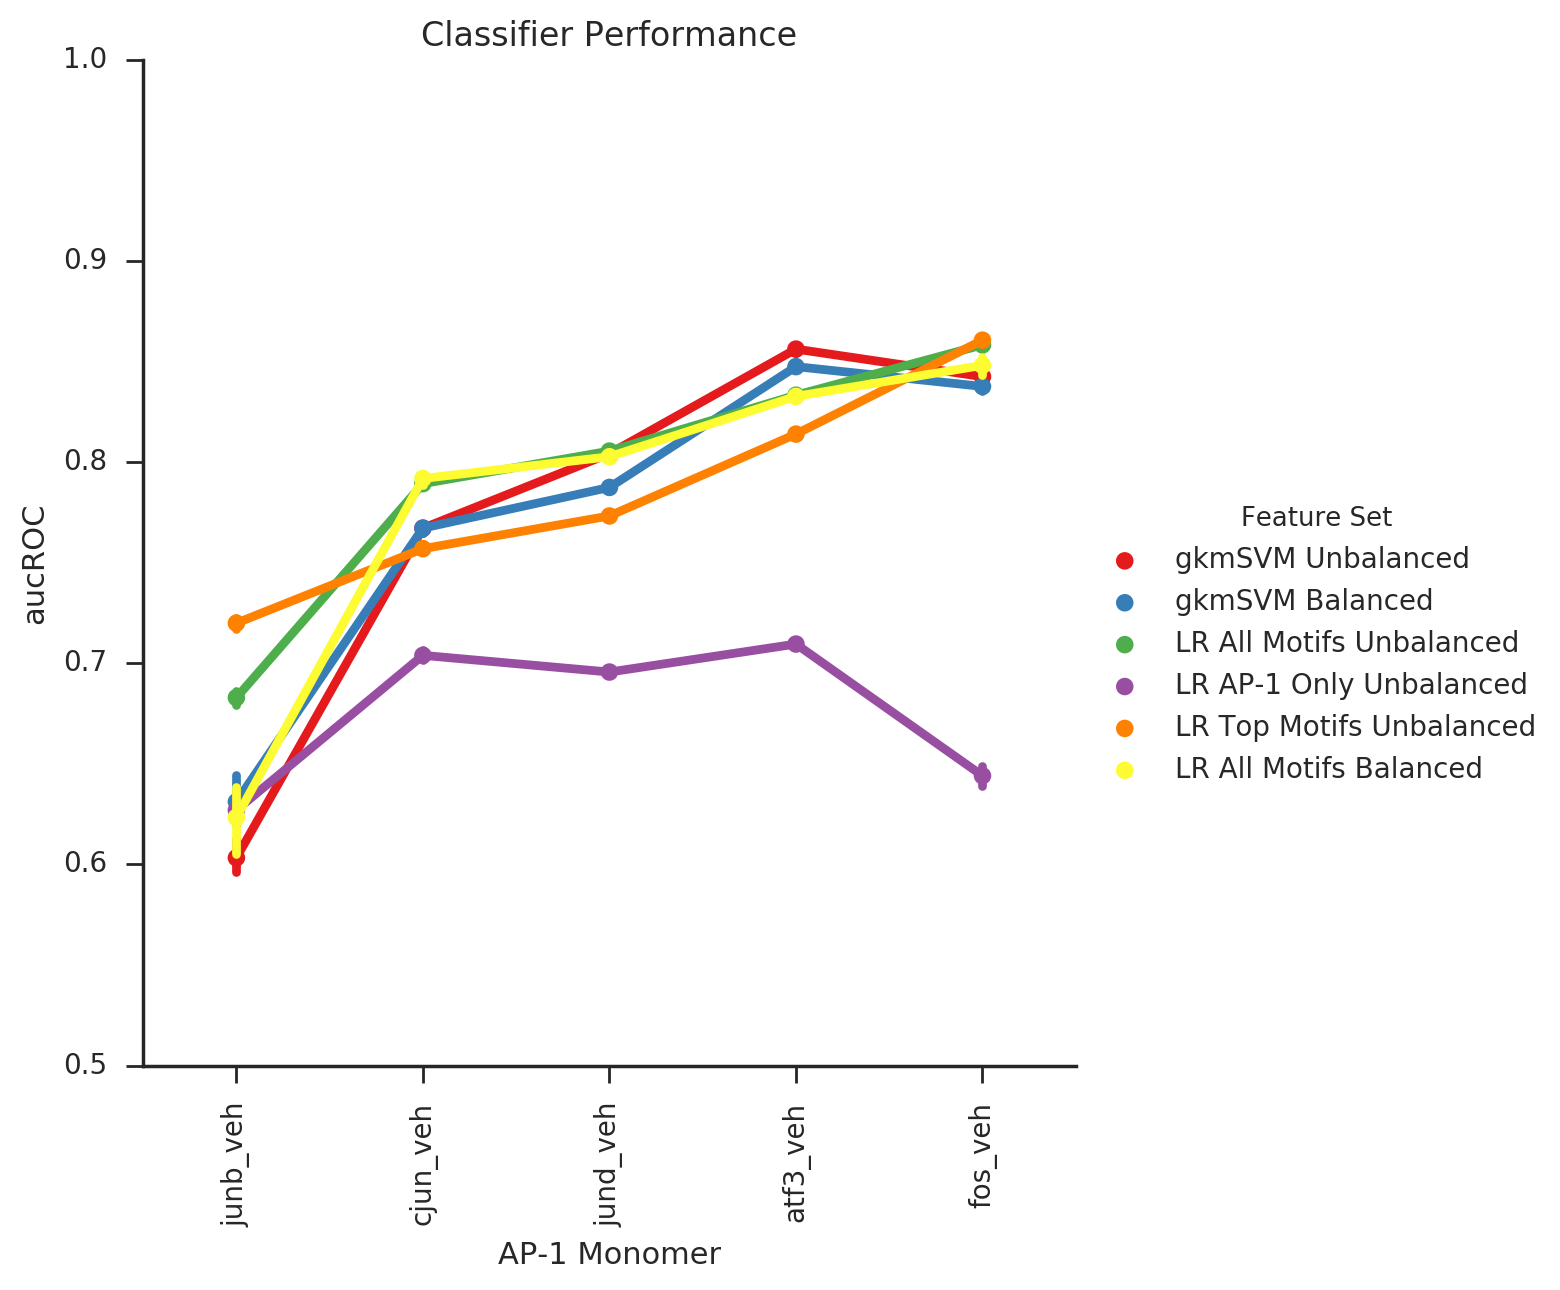

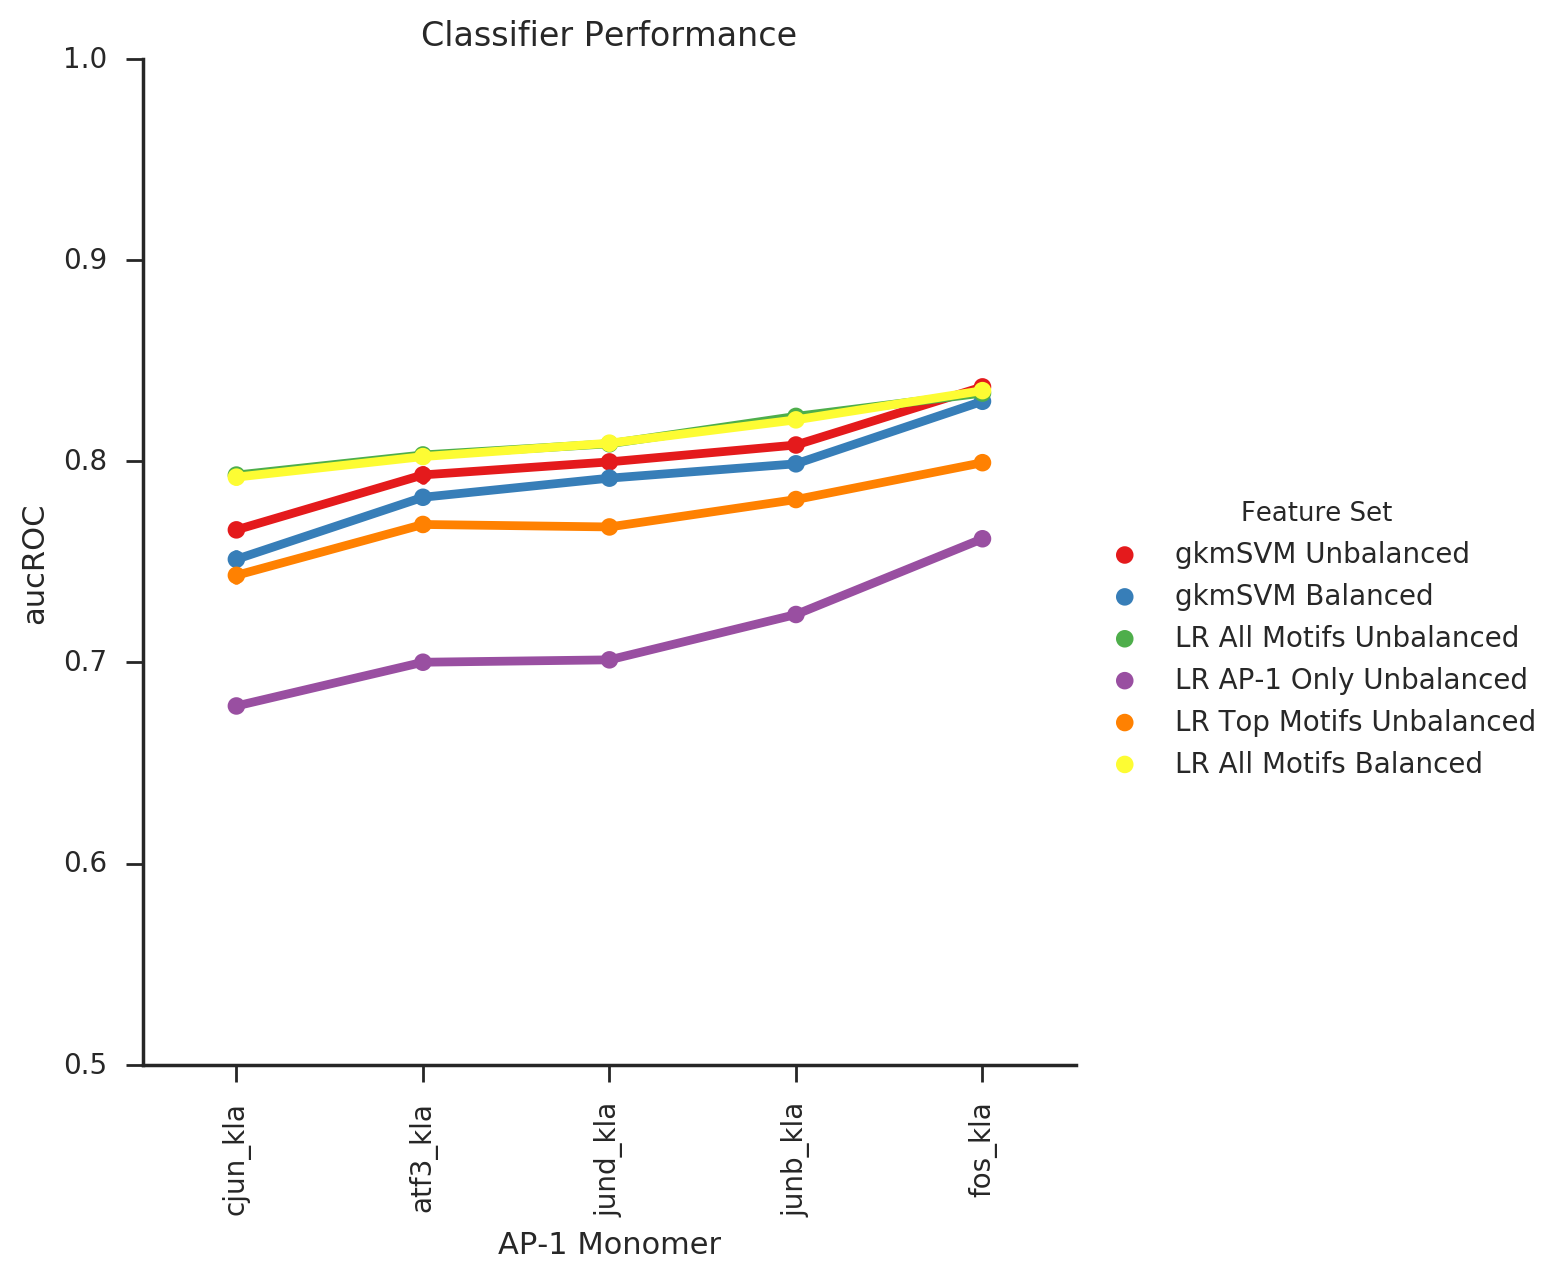

In [309]:
monomers = []
aucs = []
feature_set = []
for monomer in sorted(factor_auc_dict_lr.keys()):
        
    monomers = monomers + numIterations * [monomer]
    aucs = aucs + factor_auc_dict_unbalancedgkmSVM[monomer]
    feature_set = feature_set + numIterations * ['gkmSVM Unbalanced']
    
    monomers = monomers + numIterations * [monomer]
    aucs = aucs + factor_auc_dict_gkmSVM[monomer]
    feature_set = feature_set + numIterations * ['gkmSVM Balanced']
    
    monomers = monomers + numIterations * [monomer]
    aucs = aucs + factor_auc_dict_lr[monomer]
    feature_set = feature_set + numIterations * ['LR All Motifs Unbalanced']
    
    monomers = monomers + numIterations * [monomer]
    aucs = aucs + factor_auc_dict_lrAP1only[monomer]
    feature_set = feature_set + numIterations * ['LR AP-1 Only Unbalanced']
    
    monomers = monomers + numIterations * [monomer]
    aucs = aucs + factor_auc_dict_lrTop[monomer]
    feature_set = feature_set + numIterations * ['LR Top Motifs Unbalanced']
    
    monomers = monomers + numIterations * [monomer]
    aucs = aucs + factor_auc_dict_lrBalanced[monomer]
    feature_set = feature_set + numIterations * ['LR All Motifs Balanced']

    
data = pd.DataFrame({'Factor':monomers,
                     'AUC':aucs,
                     'Feature Set': feature_set
                     })

# Vehicle plot
# sort monomers according to ascending AUC with all motifs
for treatment in ['veh', 'kla']:
    factor_auc_tuples = [(x, np.mean(factor_auc_dict_lr[x])) for x in factor_auc_dict_lr if treatment in x]

    sorted_monomers = [y[0] for y in sorted(factor_auc_tuples, key=lambda x:x[1])]

    with sns.axes_style('ticks'):
        plottingFrame = sns.factorplot(data = data[data['Factor'].str.contains(treatment)],
                                    x='Factor',
                                    y='AUC',
                                    order = sorted_monomers,
                                    palette='Set1',
                                    size=6,
                                    hue='Feature Set',
                                    kind = 'point', 
                                    markers = '.', s='0.01')
        sns.despine()
        plt.xticks(rotation=90)
        plt.ylabel('aucROC')
        plt.xlabel('AP-1 Monomer')
        plt.ylim(0.5,1)
        plt.title('Classifier Performance')
        plt.show()



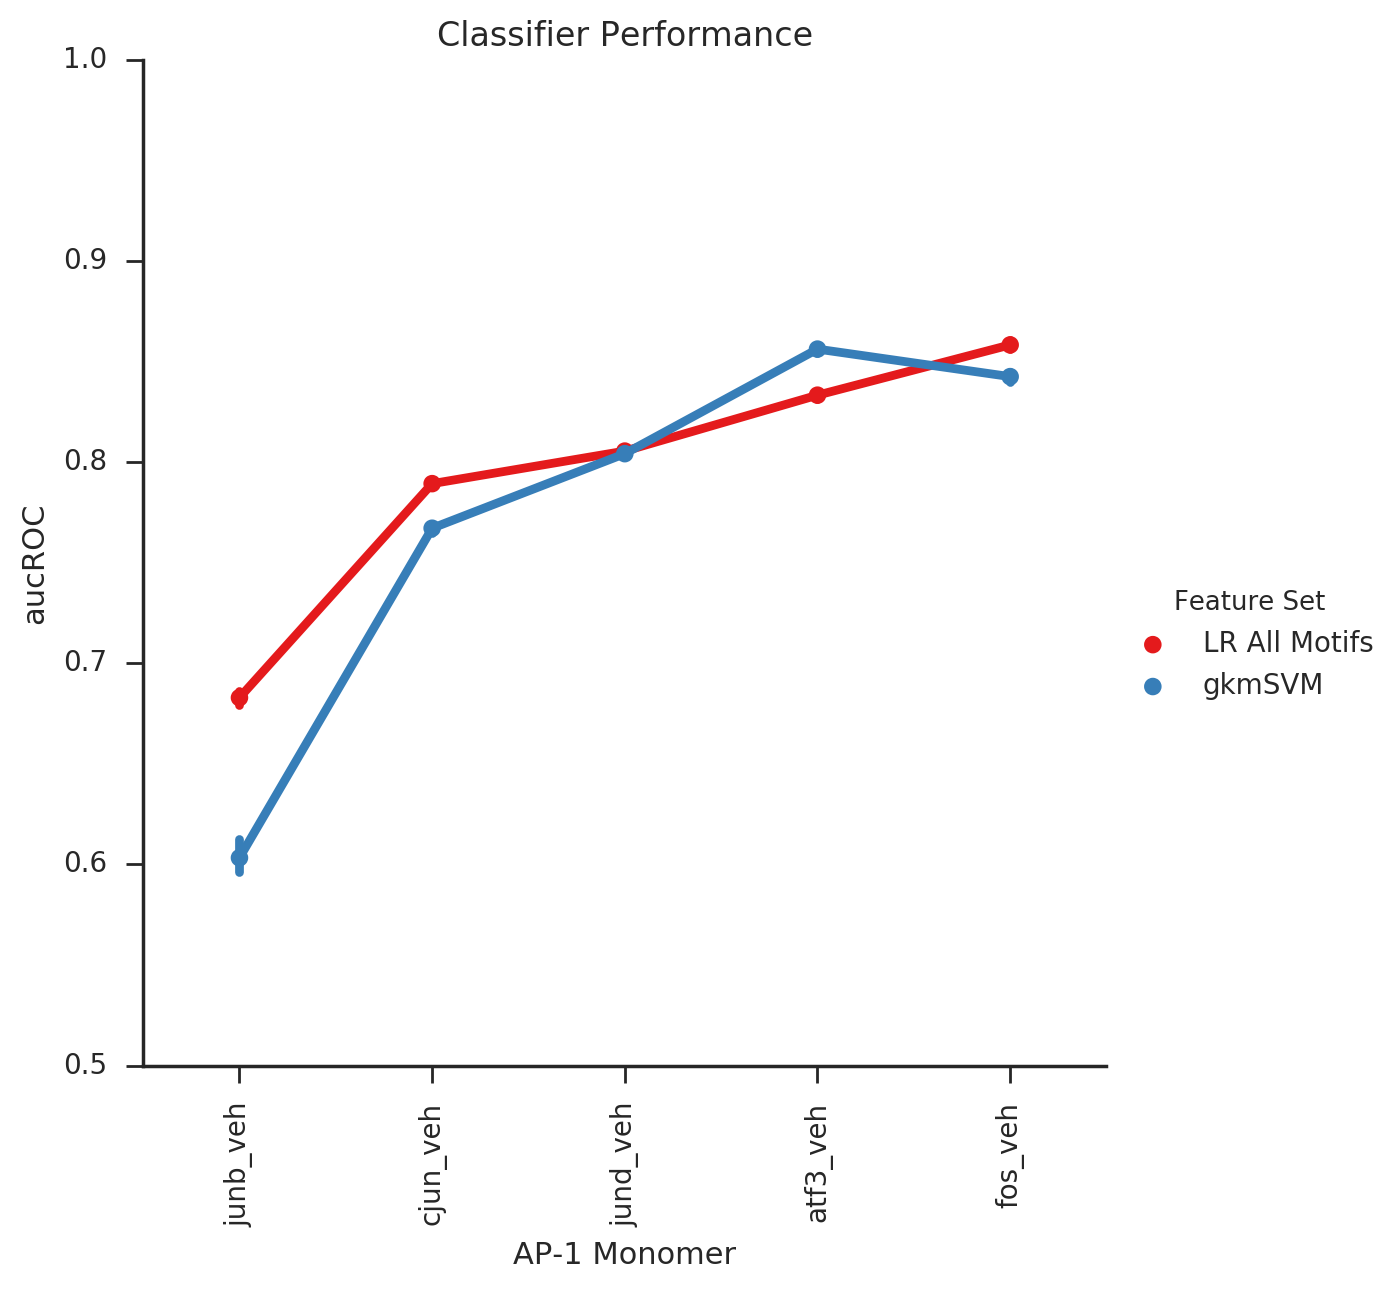

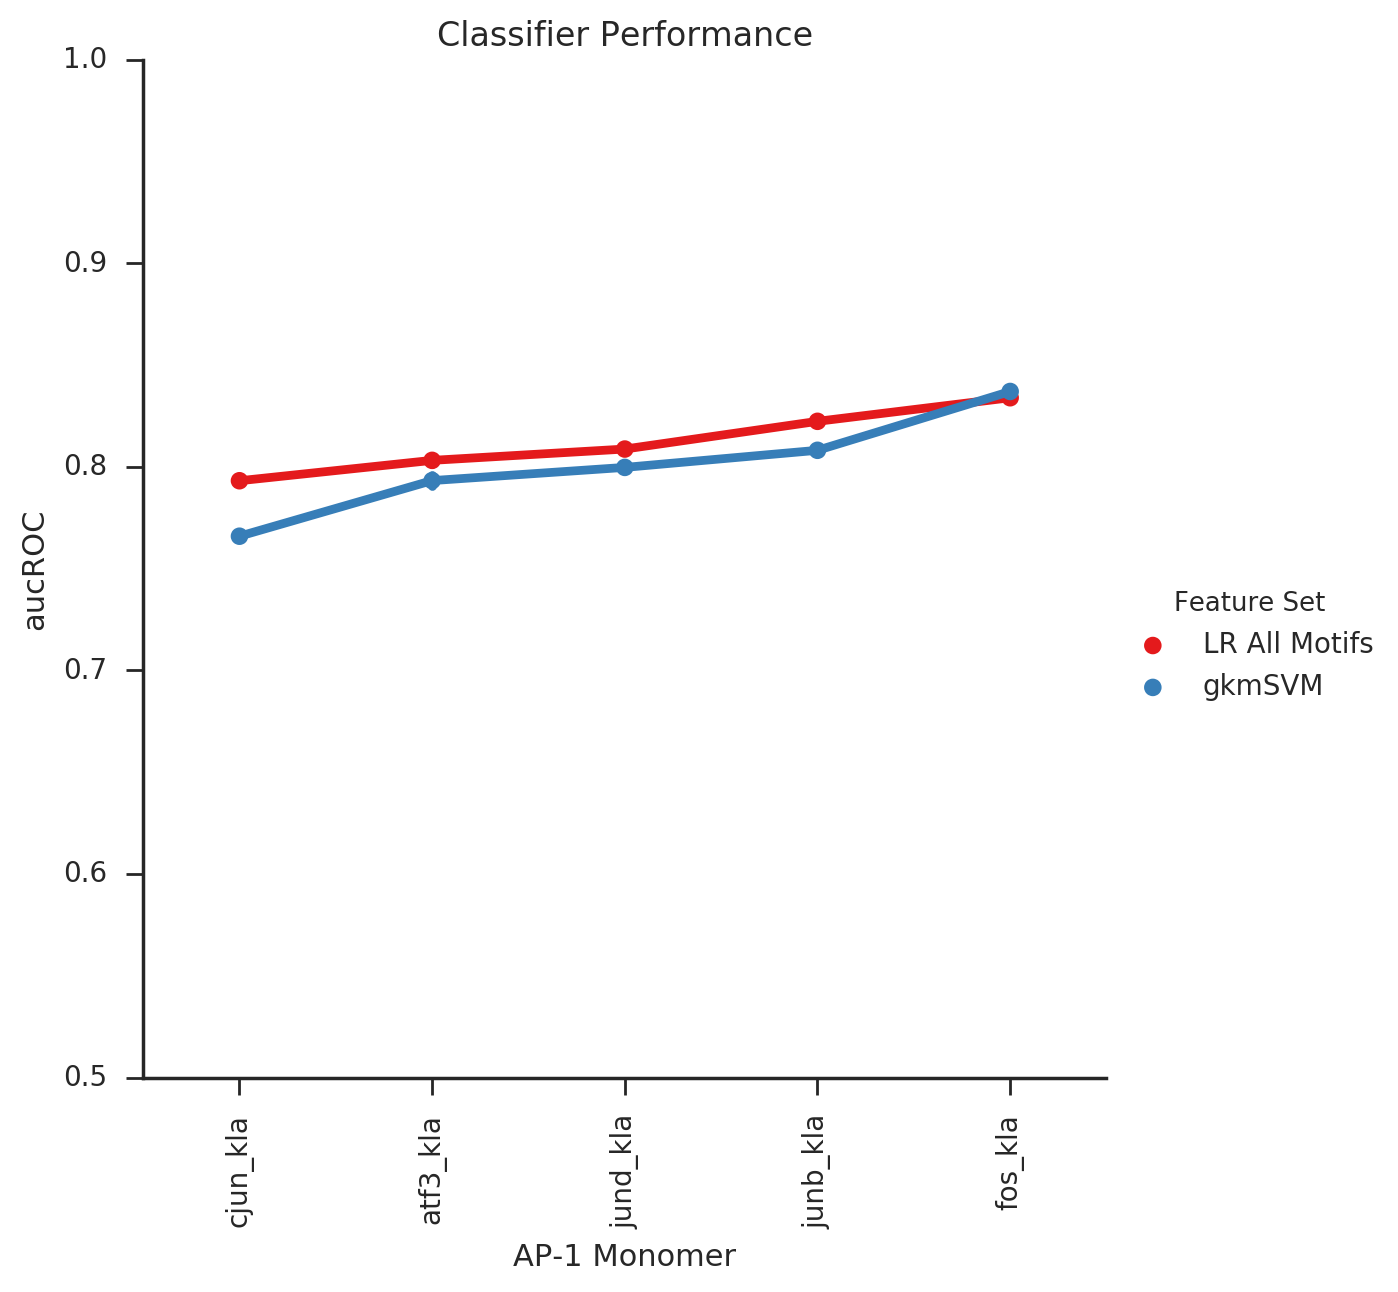

In [308]:
monomers = []
aucs = []
feature_set = []
for factor in sorted(factor_auc_dict_lr.keys()):
    monomers = monomers + numIterations * [factor]
    aucs = aucs + factor_auc_dict_lr[factor]
    feature_set = feature_set + numIterations * ['LR All Motifs']
    
    monomers = monomers + numIterations * [factor]
    aucs = aucs + factor_auc_dict_unbalancedgkmSVM[factor]
    feature_set = feature_set + numIterations * ['gkmSVM']
    
data = pd.DataFrame({'Factor':monomers,
                     'AUC':aucs,
                     'Feature Set': feature_set
                     })

# vehicle plot


for treatment in ['veh', 'kla']:
    factor_auc_tuples = [(x, np.mean(factor_auc_dict_lr[x])) for x in factor_auc_dict_lr if treatment in x]
    sorted_monomers = [y[0] for y in sorted(factor_auc_tuples, key=lambda x:x[1])]
    with sns.axes_style('ticks'):
        plottingFrame = sns.factorplot(data = data[data['Factor'].str.contains(treatment)],
                                    x='Factor',
                                    y='AUC',
                                    order = sorted_monomers,
                                    palette='Set1',
                                    size=6,
                                    hue='Feature Set',
                                    kind = 'point', 
                                    markers = '.', s='0.01')
        sns.despine()
        plt.xticks(rotation=90)
        plt.ylabel('aucROC')
        plt.xlabel('AP-1 Monomer')
        plt.ylim(0.5,1)
        plt.title('Classifier Performance')
        plt.show()

    

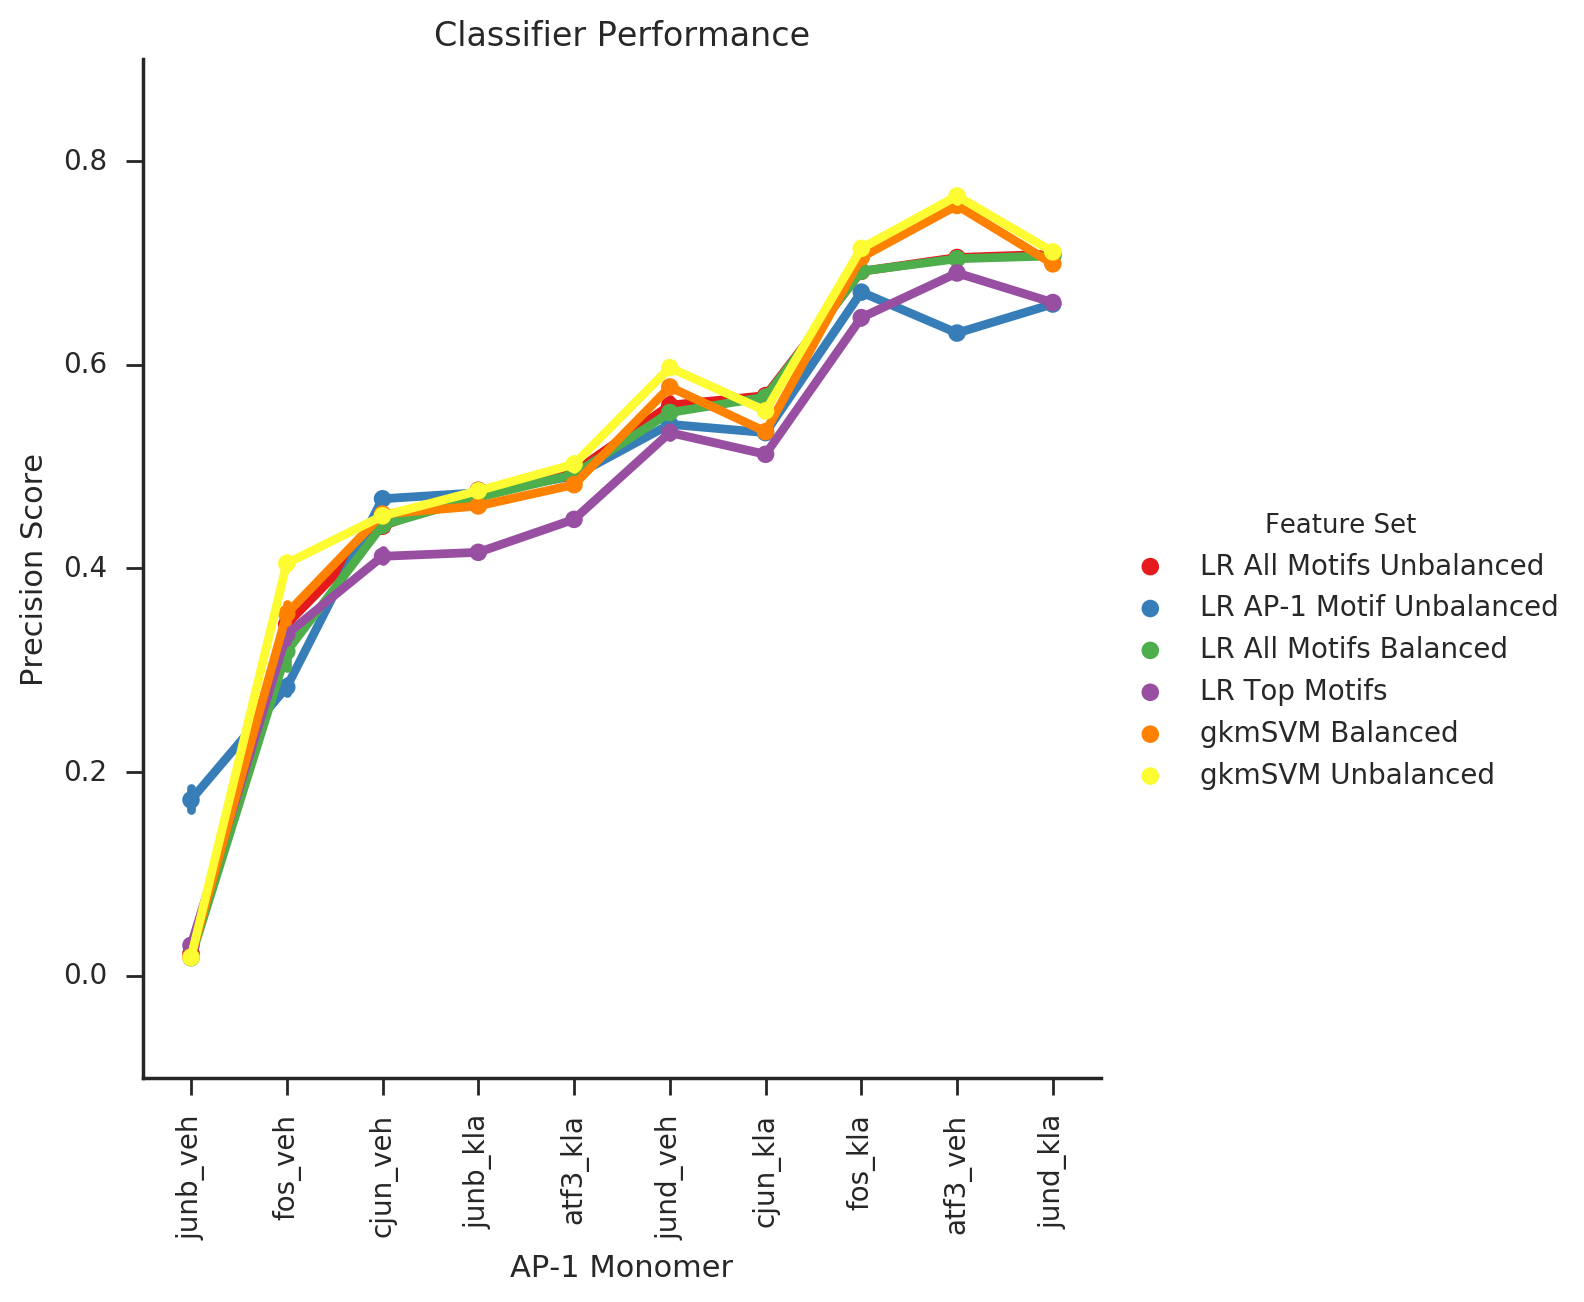

In [289]:
monomers = []
precisions = []
feature_set = []
for factor in sorted(factor_precision_dict_lr.keys()):
    monomers = monomers + numIterations * [factor]
    precisions = precisions + factor_precision_dict_lr[factor]
    feature_set = feature_set + numIterations * ['LR All Motifs Unbalanced']

    monomers = monomers + numIterations * [factor]
    precisions = precisions + factor_precision_dict_lrAP1only[factor]
    feature_set = feature_set + numIterations * ['LR AP-1 Motif Unbalanced']
    
    monomers = monomers + numIterations * [factor]
    precisions = precisions + factor_precision_dict_lrBalanced[factor]
    feature_set = feature_set + numIterations * ['LR All Motifs Balanced']
    
    monomers = monomers + numIterations * [factor]
    precisions = precisions + factor_precision_dict_lrTop[factor]
    feature_set = feature_set + numIterations * ['LR Top Motifs']
    
    monomers = monomers + numIterations * [factor]
    precisions = precisions + factor_precision_dict_gkmSVM[factor]
    feature_set = feature_set + numIterations * ['gkmSVM Balanced']
    
    monomers = monomers + numIterations * [factor]
    precisions = precisions + factor_precision_dict_unbalancedgkmSVM[factor]
    feature_set = feature_set + numIterations * ['gkmSVM Unbalanced']
    
data = pd.DataFrame({'Factor':monomers,
                     'Precision Score':precisions,
                     'Feature Set': feature_set
                     })

for treatment in ['veh', 'kla']:
    # sort monomers according to ascending precision with all motifs
    factor_precision_tuples = [(x, np.mean(factor_precision_dict_lr[x])) for x in factor_precision_dict_lr if treatment in x]

    sorted_monomers = [y[0] for y in sorted(factor_precision_tuples, key=lambda x:x[1])]

    with sns.axes_style('ticks'):
        plottingFrame = sns.factorplot(data = data[data['Factor'].str.contains(treat,
                                    x='Factor',
                                    y='Precision Score',
                                    order = sorted_monomers,
                                    palette='Set1',
                                    size=6,
                                    hue='Feature Set',
                                    kind = 'point', 
                                    markers = '.', s='0.01')
        sns.despine()
        plt.xticks(rotation=90)
        plt.ylabel('Precision Score')
        plt.xlabel('AP-1 Monomer')
        plt.title('Classifier Performance')

    